# 資料處理
---

In [1]:
import pandas as pd
df_train = pd.read_csv(r'D:\chewei\機器學習\kaggle\data\train.csv')
df_test = pd.read_csv(r'D:\chewei\機器學習\kaggle\data\test.csv')

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [3]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
from sklearn.preprocessing import LabelEncoder
# One-Hot: 類別間無順序。一個類別用一行，用0與1表示。
# Label Encoding: 類別間有順序。不同類別用0、1、2...表示。
# 1. person_home_ownership: One-Hot
df_train = pd.get_dummies(df_train, columns=['person_home_ownership'], drop_first=False)
df_test = pd.get_dummies(df_test, columns=['person_home_ownership'], drop_first=False)

# 2. loan_grade: Label Encoding
le_grade = LabelEncoder()
df_train['loan_grade'] = le_grade.fit_transform(df_train['loan_grade'])
df_test['loan_grade'] = le_grade.transform(df_test['loan_grade'])

# 3. cb_person_default_on_file: Label Encoding
le_default = LabelEncoder()
df_train['cb_person_default_on_file'] = le_default.fit_transform(df_train['cb_person_default_on_file'])
df_test['cb_person_default_on_file'] = le_default.transform(df_test['cb_person_default_on_file'])

loan_intent
DEBTCONSOLIDATION    0.189313
MEDICAL              0.178251
HOMEIMPROVEMENT      0.173726
PERSONAL             0.132788
EDUCATION            0.107734
VENTURE              0.092798
Name: loan_status, dtype: float64


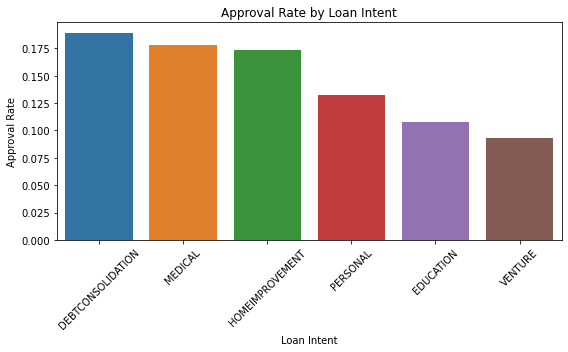

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 針對 'loan_intent' 計算每個類別的核准率（target mean encoding）

# 計算每個 loan_intent 的核准率
loan_intent_approval_rate = df_train.groupby('loan_intent')['loan_status'].mean().sort_values(ascending=False)

# 顯示計算結果
print(loan_intent_approval_rate)

# 畫出核准率的柱狀圖
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_intent_approval_rate.index, y=loan_intent_approval_rate.values)
plt.title('Approval Rate by Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
def target_mean_encoding(df, categorical_column, target_column):
    """
    對類別型特徵做 Target Mean Encoding。
    
    參數：
    - df: 原始資料集（pandas DataFrame）
    - categorical_column: 要編碼的類別欄位（字串）
    - target_column: 目標欄位
    
    輸出：
    - df_encoded: 新的資料集（原本的類別欄位會被數值欄位取代）
    - encoding_map: 類別 ➔ 核准率 的映射表
    """
    # 1. 計算每個類別的 target 平均值（核准率)
    encoding_map = df.groupby(categorical_column)[target_column].mean().to_dict()
    
    # 2. 替換原本的類別欄位，變成對應的平均核准率
    df_encoded = df.copy()
    df_encoded[categorical_column + '_encoded'] = df_encoded[categorical_column].map(encoding_map)
    
    return df_encoded, encoding_map

# 套用在 'loan_intent' 欄位
df_train_encoded, loan_intent_map = target_mean_encoding(df_train, 'loan_intent', 'loan_status')
df_test_encoded = df_test.copy()
df_test_encoded['loan_intent_encoded'] = df_test_encoded.loc[:,'loan_intent'].map(loan_intent_map)

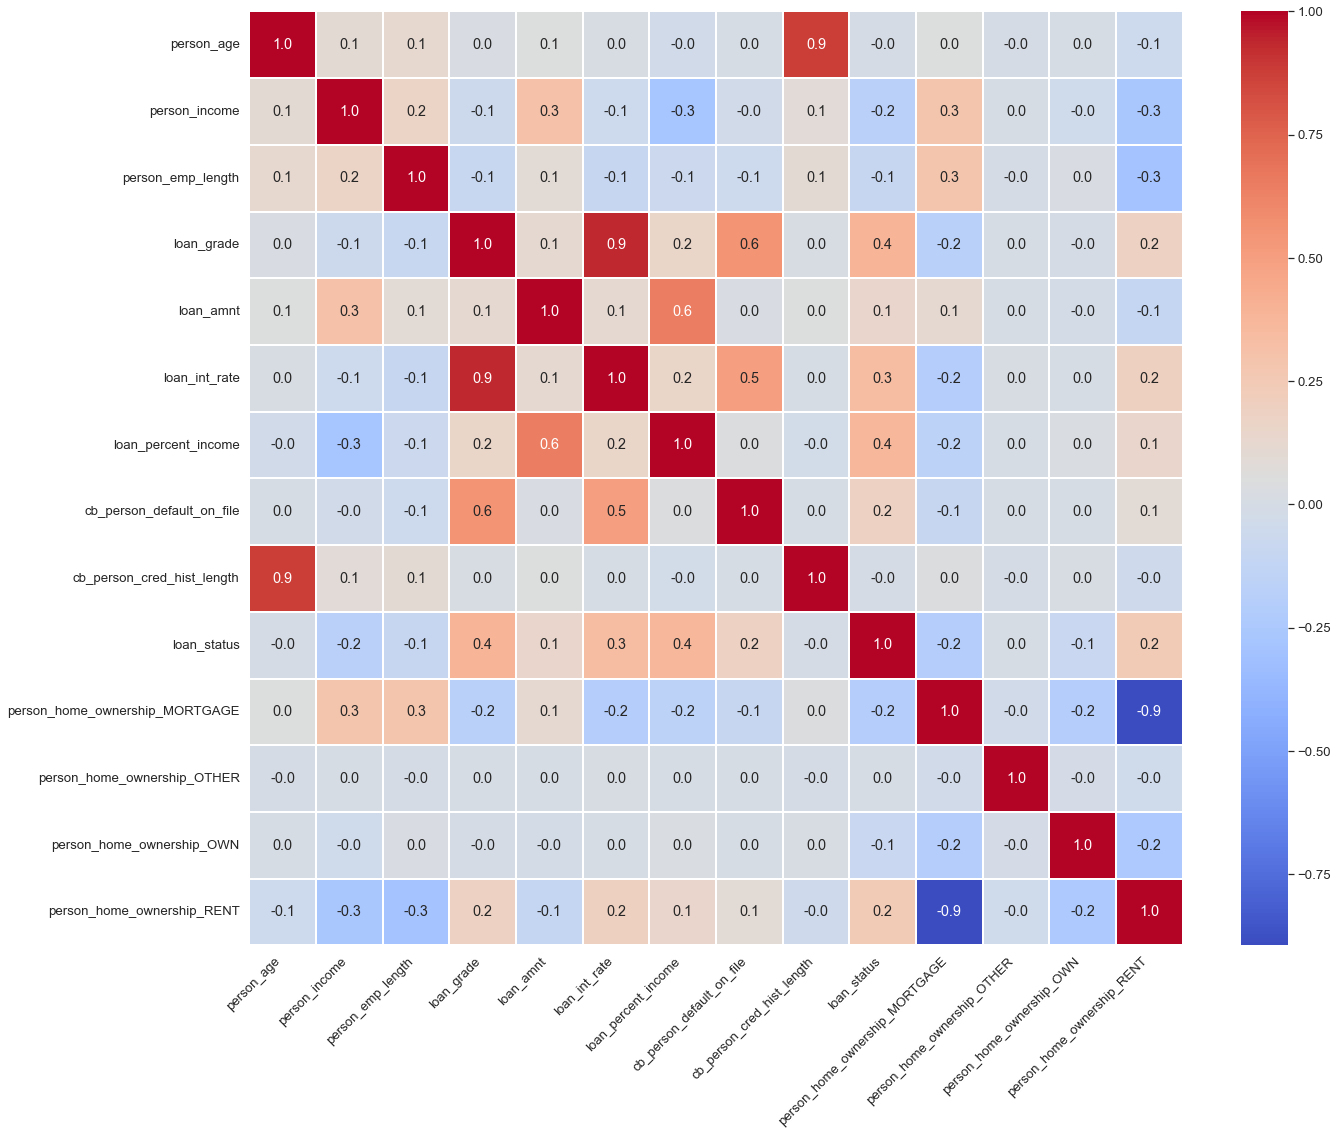

In [7]:
import seaborn as sns
# train = pd.get_dummies(train, columns=['loan_intent'], drop_first=True)
heat_data = df_train_encoded.drop(columns=['id','loan_intent']).corr()


plt.figure(figsize=(20, 16))  
sns.set(font_scale=1.2)        
sns.heatmap(heat_data, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.2)

plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)              
plt.tight_layout()                 

plt.show()

# 訓練模型
---

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd


# 分割特徵與目標
X = df_train_encoded.drop(columns=["id", "loan_intent","loan_status"])
y = df_train_encoded["loan_status"]

# 切割訓練集與驗證集
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 建立 AdaBoost 模型
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(
    base_estimator=base_model,
    n_estimators=200,
    learning_rate=0.8,
    random_state=42
)

# 訓練模型
adaboost_model.fit(X_train, y_train)

# validation
y_pred_proba = adaboost_model.predict_proba(X_valid)[:, 1]
y_pred = adaboost_model.predict(X_valid)

auc_score = roc_auc_score(y_valid, y_pred_proba)
report = classification_report(y_valid, y_pred)

In [27]:
auc_score

0.9329404120479591

In [23]:
# test
X_test = df_test_encoded.drop(columns=['id','loan_intent'])
y_pred_test = adaboost_model.predict_proba(X_test)[:, 1]

In [ ]:
submission = pd.read_csv(r'D:\chewei\機器學習\kaggle\data\sample_submission.csv')
submission.loc[:,'loan_status'] = y_pred_test
submission

## 使用Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import numpy as np


# 分割特徵與目標
X = df_train_encoded.drop(columns=["id", "loan_intent","loan_status"])
y = df_train_encoded["loan_status"]

# 建立交叉驗證器
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 預留紀錄
oof_preds = np.zeros(len(X))  # Out-Of-Fold 預測分數
fold_scores = []              # 記錄每折的AUC

# 開始K折訓練
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 建立AdaBoost模型
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        learning_rate=0.8,
        random_state=42
    )
    
    # 訓練
    model.fit(X_train, y_train)
    
    # 預測
    val_preds = model.predict_proba(X_val)[:, 1]
    
    # 記錄這折的預測結果
    oof_preds[val_idx] = val_preds
    
    # 計算AUC
    fold_auc = roc_auc_score(y_val, val_preds)
    fold_scores.append(fold_auc)
    
    print(f"Fold {fold+1} AUC: {fold_auc:.4f}")


Fold 1 AUC: 0.9176
Fold 2 AUC: 0.9274
Fold 3 AUC: 0.9214
Fold 4 AUC: 0.9321
Fold 5 AUC: 0.9294


In [34]:
train_idx, val_idx

(array([    0,     1,     2, ..., 58641, 58643, 58644]),
 array([    5,    10,    12, ..., 58632, 58639, 58642]))

In [30]:
auc_score

0.9329404120479591